# Solving Systems of ODEs

Created: 18 June 2021 <br/>
Last edited: 18 June 2021 <br/>
Teng-Jui Lin

Content adapted from UW CHEME 375, Chemical Engineering Computer Skills, in Spring 2021.

In this notebook, we explore the implementation of

- solving ODEs using `scipy.integrate.solve_ivp()`
- solving systems of ODEs using `scipy.integrate.solve_ivp()`

## Chemical kinetics of one reaction
**Problem Statement.** Given a first order reaction $\mathrm{A \to B}$ in a batch reactor, the concentration of species $\mathrm{A}$ is given by the ODE

$$\dfrac{dC_A}{dt} = -k C_A.$$

Solve the system analytically and numerically using Euler's method, given that the initial concentration of $\mathrm{A}$  is $4 \ \mathrm{M}$. The reaction time is 15 min, and rate constant $k$ is $0.36 \ \mathrm{min^{-1}}$. Plot the solution curves.

**Solution.** We can solve the initial value problem analytically using separation of variables, having

$$
\begin{aligned}
\dfrac{dC_A}{dt} &= -k C_A \\
\int\dfrac{dC_A}{C_A} &= \int-k dt \\
\ln C_A &= -kt+D \\
C_A &= Ae^{-kt}.
\end{aligned}
$$

Because we have an initial value of $4 \ \mathrm{M}$, we have $\boxed{C_A = 4e^{-kt}}$.

Using Euler's method, we can numerically solve the system with

$$C_A(t_{i+1}) = C_A(t_i) + (t_{i+1}-t_i)\dfrac{dC_A(t_i)}{dt}$$

through iterations.

### Implementation

In this approach, we use Euler's method and [`scipy.integrate.solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to solve the ODE.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
def dCA_dt(k, CA):
    return -k*CA

In [3]:
# known values
CA0 = 4  # M
k = 0.36  # min-1
t_final = 15  # min
dt = 0.5  # time step

# list of variables
t = np.arange(0, t_final+dt, dt)
CA_euler = np.zeros_like(t)
CA_euler[0] = CA0

# euler's method
for i in range(len(t)-1):
    CA_euler[i+1] = CA_euler[i] + dt*dCA_dt(k, CA_euler[i])

In [4]:
def CA(k, t):
    return 4*np.exp(-k*t)

In [5]:
CA_analytic = CA(k, t)

In [6]:
# plot settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'cm',
    'font.size': 18,
    
    'lines.linewidth': 2,
    
    'axes.linewidth': 2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',
    
    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,
    
    'figure.dpi': 80,
    
    'legend.framealpha': 1, 
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14
})

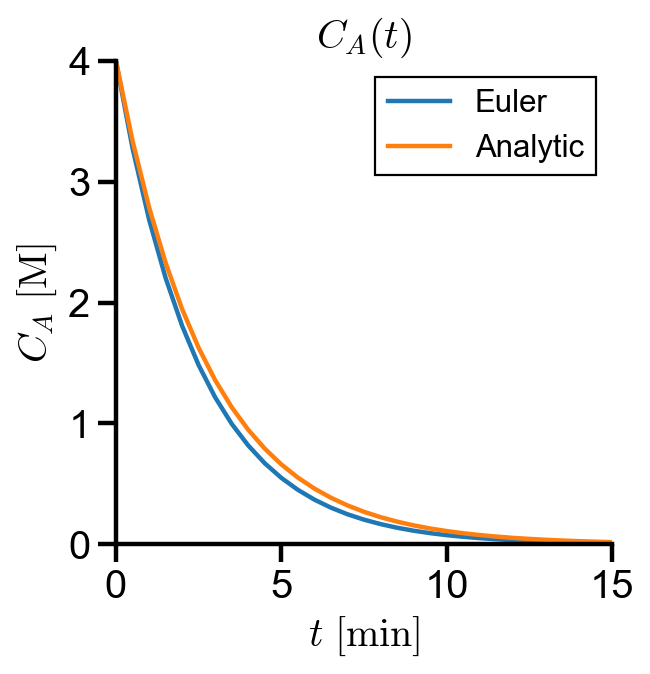

In [7]:
# plot CA vs t
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(t, CA_euler, label='Euler')
ax.plot(t, CA_analytic, label='Analytic')
ax.set_title('$C_A(t)$')
ax.set_xlabel('$t \ [\mathrm{min}]$')
ax.set_ylabel('$C_A \ [\mathrm{M}]$')
ax.axis([0, t_final, 0, CA0])
ax.legend()

By inspection, we can see that there is error associated with Euler's method. 

## Chemical kinetics of reaction networks
**Problem Statement.** A batch reactor has a set of reactions

- $\mathrm{A} \to 2\mathrm{B}$
- $2\mathrm{B} \to \mathrm{C}$

with concentrations governed by the system of ODEs

- $\dfrac{dC_A}{dt} = -k_1C_A$
- $\dfrac{dC_B}{dt} = 2k_1C_A - k_2C_B^2$
- $\dfrac{dC_C}{dt} = 0.5k_2C_B^2$

(a) Solve the concentration over time for 8 hours given initial concentration $C_A(0) = 10 \ \mathrm{M}$. Given rate constants $k_1 = 0.92 \ \mathrm{h^{-1}}, k_2 = 0.08 \ \mathrm{L \ mol^{-1}\ h^{-1}}$.

(b) Determine the maximum concentration of $\mathrm{B}$ and the time at which it attains the maximum.

**Solution.** The system of ODEs is already in the form of $f'(t, C) = f(t, C)$. We can use `solve_ivp()` to solve for concentration over time.

### Implementation

In this approach, we use [`scipy.integrate.solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to solve the system of ODEs.

In [8]:
def ODEsyst2(x, Y):
    # x -> independent variable
    # Y -> functions evaluated at independent variable
    CA, CB, CC = Y
    k1, k2 = [0.92, 0.08]
    odes = np.array([
        -k1*CA,
        2*k1*CA - k2*CB**2,
        0.5*k2*CB**2
    ])
    return odes

In [9]:
domain = [0, 8]
initial_values = [10, 0, 0]
x_eval = np.arange(0, 8.1, 0.1)
soln = solve_ivp(ODEsyst2, domain, initial_values, t_eval=x_eval)
t = soln.t
CA, CB, CC = soln.y

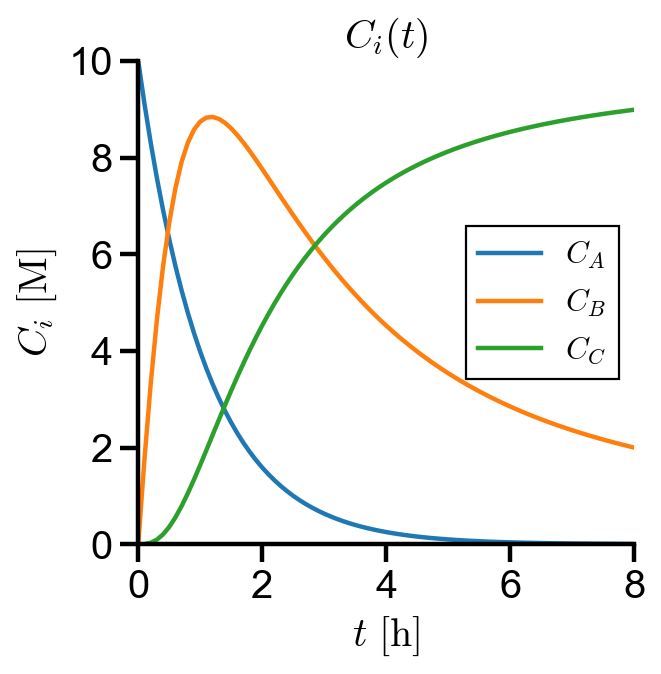

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(t, CA, label='$C_A$')
ax.plot(t, CB, label='$C_B$')
ax.plot(t, CC, label='$C_C$')
ax.set_title('$C_i(t)$')
ax.set_xlabel('$t \ [\mathrm{h}]$')
ax.set_ylabel('$C_i \ [\mathrm{M}]$')
ax.set_xlim(0, 8)
ax.set_ylim(0, 10)
ax.legend()

In [11]:
CB_max = CB.max()
CB_max

8.84376537393465

In [12]:
CB_max_time = t[CB.argmax()]
CB_max_time

1.2000000000000002

In [13]:
print(f'Maximum concentration of B = {CB_max:.2f} M')
print(f'Time when concentration of B is at maximum = {CB_max_time:.1f} h')

Maximum concentration of B = 8.84 M
Time when concentration of B is at maximum = 1.2 h
